In [1]:
# 加载必要的库
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# 加载数据集
train_set = h5py.File("./datasets/train_catvnoncat.h5","r")
test_set = h5py.File("./datasets/test_catvnoncat.h5","r")

for key in train_set.keys():  # 查看训练集结构
    print(key)   # train_set_x  train_set_y
train_set['train_set_x'].shape # (209, 64, 64, 3) 有209张图片，图片分辨率64*64，颜色通道为3
train_set['train_set_y'].shape # (209,) 标注图片标签（是否为猫）

for key in test_set.keys():  # 查看测试集结构
    print(key)    # test_set_x   test_set_y
test_set['test_set_x'].shape # (50, 64, 64, 3) 有50张图片，图片分辨率64*64，颜色通道为3 
test_set['test_set_y'].shape # (50,) 标注图片标签（是否为猫）

# 将数据集中的内容和标签分开
train_data_org = train_set['train_set_x'][:]  # 保存的是训练集里面的图像数据，即209张64x64的3通道图像
train_labels_org = train_set['train_set_y'][:] # 保存的是训练集的图像对应的分类值，其中0表示不是猫，1表示是猫
test_data_org = test_set['test_set_x'][:] # 保存的是测试集里面的图像数据，即50张64x64的3通道图像
test_labels_org = test_set['test_set_y'][:] # 保存的是测试集里面的图像对应的分类值，其中0表示不是猫，1表示是猫

list_classes
train_set_x
train_set_y
list_classes
test_set_x
test_set_y


In [3]:
# 处理数据集------维度处理
# 对于训练集样本：(209, 64, 64, 3) ----> (12288, 209) 
# 对于测试集样本：(50, 64, 64, 3) ----->(12288, 50)
m_train = train_data_org.shape[0] # 训练集个数
m_test = test_data_org.shape[0] # 测试集个数
train_data_trans = train_data_org.reshape(m_train,-1).T # 训练集维度处理
test_data_trans = test_data_org.reshape(m_test,-1).T # 测试集维度处理
print(train_data_org.shape,test_data_org.shape)
print(train_data_trans.shape,test_data_trans.shape)

import numpy as np
# 对于训练集标签：(209,) ----> (1, 209)
# 对于测试集标签：(50,) -----> (1, 50)
train_labels_trans = train_labels_org.reshape(1,m_train) # 训练集标签维度处理
test_labels_trans = test_labels_org.reshape(1,m_test) # 训练集标签维度处理
print(train_labels_org.shape,test_labels_org.shape)
print(train_labels_trans.shape,test_labels_trans.shape)

(209, 64, 64, 3) (50, 64, 64, 3)
(12288, 209) (12288, 50)
(209,) (50,)
(1, 209) (1, 50)


In [4]:
# 处理数据集------标准化数据
train_data_norm = train_data_trans / 255
test_data_norm = test_data_trans / 255
print(train_data_trans)
print(train_data_norm)

[[ 17 196  82 ... 143  22   8]
 [ 31 192  71 ... 155  24  28]
 [ 56 190  68 ... 165  23  53]
 ...
 [  0  82 138 ...  85   4   0]
 [  0  80 141 ... 107   5   0]
 [  0  81 142 ... 149   0   0]]
[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


In [5]:
# 定义超参数
EPOCHS = 3000
ALPHA = 0.0075
layers_dims = [12288, 20, 7, 5 ,1]

In [6]:
# 初始化参数

# 注意：！！！！！！！！！！！
# 这里对权重矩阵初始化方法与之前几章的方法不同！！！！！

def init_params(layer):
    n_x = layers_dims[layer-1]
    n_h = layers_dims[layer]
    W = np.random.randn(n_h,n_x)/np.sqrt(layers_dims[layer - 1])
    b = np.zeros((n_h,1))
    return W,b

In [7]:
# 前向和反向传播
def deep_forward_backward(X, Y, W1, W2, W3, W4, b1, b2, b3, b4):
    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0,Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = np.maximum(0,Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = np.maximum(0,Z3)
    Z4 = np.dot(W4, A3) + b4
    A4 = 1/(1+np.exp(-Z4))
    
    m = X.shape[1]
    cost = -np.sum(Y*np.log(A4) + (1 - Y)*np.log(1 - A4))/m
    
    dZ4 = A4 - Y
    dW4 = np.dot(dZ4, A3.T)/m
    db4 = dZ4.sum(axis = 1, keepdims = True)/m
    dA3 = np.dot(W4.T, dZ4)
    
    dZ3 = np.array(dA3, copy=True) 
    dZ3[A3 <= 0] = 0
    dW3 = np.dot(dZ3, A2.T)/m
    db3 = dZ3.sum(axis = 1, keepdims = True)/m
    dA2 = np.dot(W3.T, dZ3)
    
    dZ2 = np.array(dA2, copy=True) 
    dZ2[A2 <= 0] = 0
    dW2 = np.dot(dZ2, A1.T)/m
    db2 = dZ2.sum(axis = 1, keepdims = True)/m
    dA1 = np.dot(W2.T, dZ2)
    
    dZ1 = np.array(dA1, copy=True) 
    dZ1[A1 <= 0] = 0
    dW1 = np.dot(dZ1, X.T)/m
    db1 = dZ1.sum(axis = 1, keepdims = True)/m
    dX = np.dot(W1.T, dZ1)

    W1 = W1 - ALPHA*dW1
    W2 = W2 - ALPHA*dW2
    W3 = W3 - ALPHA*dW3
    W4 = W4 - ALPHA*dW4
    b1 = b1 - ALPHA*db1
    b2 = b2 - ALPHA*db2 
    b3 = b3 - ALPHA*db3
    b4 = b4 - ALPHA*db4
    
    return W1, W2, W3, W4, b1, b2, b3, b4,cost

In [8]:
# 预测
def deep_predict( W1,W2,W3,W4,b1,b2,b3,b4,X):
    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0,Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = np.maximum(0,Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = np.maximum(0,Z3)
    Z4 = np.dot(W4, A3) + b4
    A4 = 1/(1+np.exp(-Z4))
    
    m = X.shape[1]
    y_pred = np.zeros((1,m))
    
    for i in range(m):
        if A4[:,i] > 0.5:
            y_pred[:,i] = 1
        else:
            y_pred[:,i] = 0

    return y_pred

In [9]:
# 模型整合 
def deep_nn_model(X,Y,test_data_norm,test_labels_trans):
    W1,b1 = init_params(1)
    W2,b2 = init_params(2)
    W3,b3 = init_params(3)
    W4,b4 = init_params(4)
    costs = []
    for i in range (EPOCHS):
        W1, W2, W3, W4, b1, b2, b3, b4,J = deep_forward_backward(X, Y, W1, W2, W3, W4, b1, b2, b3, b4)
        if i%100 == 0:
            costs.append(J)
            print("迭代次数为：",i,"损失是：",J)
    y_pred_train = deep_predict( W1, W2, W3, W4, b1, b2, b3, b4,X)
    y_pred_test = deep_predict( W1, W2, W3, W4, b1, b2, b3, b4,test_data_norm)
    print("训练集上的准确率：",np.mean(y_pred_train == Y)*100,'%')
    print("测试集上的准确率：",np.mean(y_pred_test == test_labels_trans)*100,'%')
    return costs, W1, W2, W3, W4, b1, b2, b3, b4

In [10]:
# 调用
costs, W1, W2, W3, W4, b1, b2, b3, b4 = deep_nn_model(train_data_norm,train_labels_trans,test_data_norm,test_labels_trans)

迭代次数为： 0 损失是： 0.7110328141967175
迭代次数为： 100 损失是： 0.5464297165619841
迭代次数为： 200 损失是： 0.4761564522749003
迭代次数为： 300 损失是： 0.41877372966927856
迭代次数为： 400 损失是： 0.34637343219929495
迭代次数为： 500 损失是： 0.2716252476433419
迭代次数为： 600 损失是： 0.1676922440393075
迭代次数为： 700 损失是： 0.09698151458498622
迭代次数为： 800 损失是： 0.06483790717267003
迭代次数为： 900 损失是： 0.0353123567458625
迭代次数为： 1000 损失是： 0.025041463284740658
迭代次数为： 1100 损失是： 0.01855960722808287
迭代次数为： 1200 损失是： 0.01440804753592514
迭代次数为： 1300 损失是： 0.011515500508412857
迭代次数为： 1400 损失是： 0.009455582240767356
迭代次数为： 1500 损失是： 0.007908282138706231
迭代次数为： 1600 损失是： 0.006741250845756274
迭代次数为： 1700 损失是： 0.005824590554874986
迭代次数为： 1800 损失是： 0.005101686465076251
迭代次数为： 1900 损失是： 0.004516415964094278
迭代次数为： 2000 损失是： 0.0040332763196660555
迭代次数为： 2100 损失是： 0.0036323976897031643
迭代次数为： 2200 损失是： 0.0032942734079370426
迭代次数为： 2300 损失是： 0.0030058985734826146
迭代次数为： 2400 损失是： 0.0027587783938383165
迭代次数为： 2500 损失是： 0.0025447738937371253
迭代次数为： 2600 损失是： 0.00235748144760995

Text(0, 0.5, 'cost')

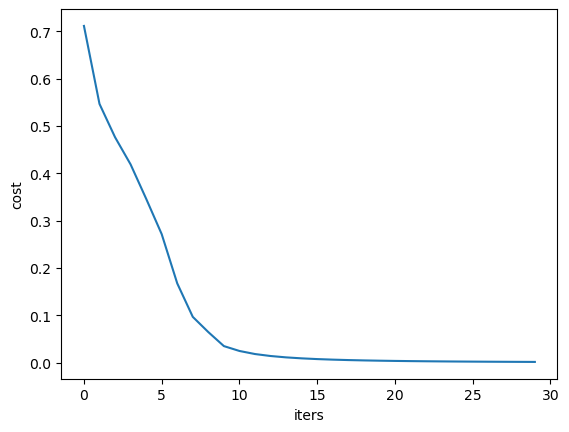

In [11]:
# 绘图
plt.plot(costs)
plt.xlabel("iters")
plt.ylabel("cost")